<a href="https://colab.research.google.com/github/hrutkabence/tutorials/blob/master/english/machine_learning/lessons/pc_dbscan_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Application of DBSCAN on point clouds

In [ ]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import os
import shutil
import random
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
pc_filename = 'Trees.ply'
new_folder = 'clusters'

In [ ]:
# Check the existance of the folder and create if it need
if os.path.isdir(new_folder) == True:
  shutil.rmtree(new_folder, ignore_errors=True)
  os.mkdir(new_folder)
else:
  os.mkdir(new_folder)

In [ ]:
eps = 0.5
min_points = 50
debug = 1

In [ ]:
# Import .PLY format point cloud and create a numpy array

pcd = o3d.io.read_point_cloud(pc_filename)
xyz = np.asarray(pcd.points)


In [ ]:
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode = 'data', #this string can be 'data', 'cube', 'auto', 'manual'
                aspectratio=dict(x=1, y=1, z=1)
            )
        )
    )
    fig.show()

In [ ]:
o3d.visualization.draw_geometries = draw_geometries # replace function
o3d.visualization.draw_geometries([pcd])

In [ ]:
# Labelling with the DBSCAN
labels = np.array(pcd.cluster_dbscan(eps, min_points))

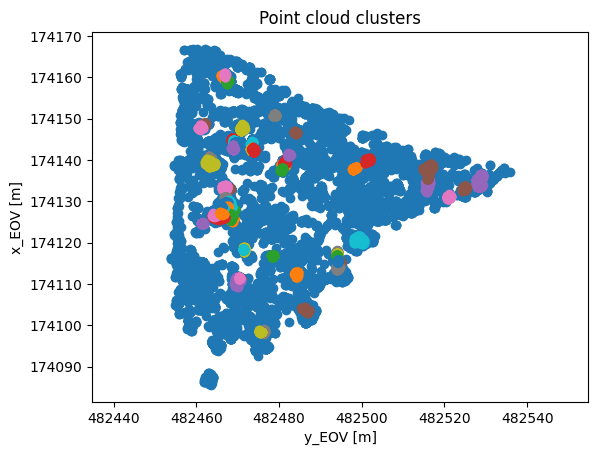

Point cloud has 65 clusters


In [ ]:

# Add clusters for loop
clusters = np.unique(labels)

# Save clusters into point clouds                                       TODO: condition aon the min. number of points
for cluster in clusters:

  # Get row indexes for samples with this cluster
  row_ix = np.where(labels == cluster)

  # Create scatter of these samples
  plt.scatter(xyz[row_ix, 0], xyz[row_ix, 1], label=str(cluster)+' cluster')

  # Export the clusters as a point cloud
  xyz_cluster = xyz[row_ix]
  pc_cluster = o3d.geometry.PointCloud()
  pc_cluster.points = o3d.utility.Vector3dVector(xyz_cluster)

  # Add a color to the point cloud
  col_r = np.full((np.shape(pc_cluster.points)[0], 1), random.uniform(0, 1))      # Create random colors for point clouds
  col_g = np.full((np.shape(pc_cluster.points)[0], 1), random.uniform(0, 1))
  col_b = np.full((np.shape(pc_cluster.points)[0], 1), random.uniform(0, 1))
  col = np.concatenate((col_r, col_g, col_b), axis=1)                             # Merge RGB values
  pc_cluster.colors = o3d.utility.Vector3dVector(col)

  # Write into a file
  if cluster >= 0:
    o3d.io.write_point_cloud(new_folder+'/cluster_' + str(cluster) + '.ply', pc_cluster) # export .ply format
  else:
    o3d.io.write_point_cloud(new_folder+'/noise.ply', pc_cluster) # export noise



# Show plot
plt.title('Point cloud clusters')
plt.xlabel('y_EOV [m]')
plt.ylabel('x_EOV [m]')
plt.axis('equal')
plt.show()

# Display point cloud
max_label = labels.max()
print(f"Point cloud has {max_label + 1} clusters")



In [ ]:
# Show result in Open3D
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

# Display point cloud
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
